In [1]:
#!pip install pyclustering
#!pip install openpyxl

## UC Irvine Machile Learning Repository: Online Retail  
- source: https://archive.ics.uci.edu/dataset/352/online+retail
- github repository:

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

Dataset Information

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.
Has Missing Values?
No

## Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Dataset Selection

In [3]:
# Load dataset
raw_online_retail = pd.read_csv('content/online_retail.csv', low_memory=False,skiprows=1)

In [4]:
raw_online_retail.shape

(541909, 8)

In [5]:
raw_online_retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom


## Data Cleaning and Preprocessing

In [6]:
# Check duplicated rows
len(raw_online_retail[raw_online_retail.duplicated])

5268

In [7]:
# Delete duplicate rows 
online_retail_2_miss=raw_online_retail.drop_duplicates(keep='last',inplace=False) 

In [8]:
n_rows, n_cols = online_retail_2_miss.shape
print(n_rows, n_cols)

536641 8


In [9]:
# Check for missing values
print(online_retail_2_miss.isna().values.any())
print(online_retail_2_miss.isnull().values.any())

True
True


In [10]:
online_retail_2_miss.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [11]:
# Check missing values percetage 
n_missing_description=online_retail_2_miss['Description'].isnull().sum()
print('Missing fields in Description column:',round((n_missing_description*100)/n_rows,2),'%')

Missing fields in Description column: 0.27 %


In [12]:
n_missing_customer=online_retail_2_miss['CustomerID'].isnull().sum()
print('Missing fields in CustomerID column:',round((n_missing_customer*100)/n_rows,2),'%')

Missing fields in CustomerID column: 25.16 %


In [13]:
# Handle missing values CustomerID
online_retail_1_miss = online_retail_2_miss.dropna(subset=['CustomerID'],inplace=False)

In [14]:
# Handle missing values
online_retail_noise = online_retail_1_miss.dropna(subset=['Description'],inplace=False)

In [15]:
# Dropping not valuable columns
online_retail = online_retail_noise.drop(['InvoiceNo','StockCode','Description'],axis=1,inplace=False)

In [16]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Quantity     401604 non-null  int64  
 1   InvoiceDate  401604 non-null  object 
 2   UnitPrice    401604 non-null  float64
 3   CustomerID   401604 non-null  float64
 4   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 18.4+ MB


In [17]:
# Separate InvoiceDate 

online_retail['InvoiceDate'] = pd.to_datetime(online_retail['InvoiceDate'], format='%m/%d/%y %H:%M')
# Extract Date and Time separately
online_retail['Invoice_Date'] = online_retail['InvoiceDate'].dt.date      # Extract Date
online_retail['Invoice_Time'] = online_retail['InvoiceDate'].dt.time      # Extract Time
online_retail.head(2)
online_retail_sep=online_retail.drop(['InvoiceDate'],axis=1,inplace=False)

In [18]:
#Handle data types
online_retail_sep['Country'] = online_retail_sep['Country'].astype(str)

In [19]:
# Find the latest purchase date in the dataset
online_retail_sep['Invoice_Date'] = pd.to_datetime(online_retail_sep['Invoice_Date'], format='%m/%d/%y')
latest_date = online_retail_sep['Invoice_Date'].max()

# Compute Recency: Days since last purchase
recency_df = online_retail_sep.groupby('CustomerID').agg({'Invoice_Date': 'max'}).reset_index()
recency_df['Recency'] = (latest_date - recency_df['Invoice_Date']).dt.days
recency_df.drop(columns=['Invoice_Date'], inplace=True)  # Remove InvoiceDate column


In [20]:
online_retail_sep['Total_Spend'] = online_retail_sep['Quantity'] * online_retail_sep['UnitPrice']  # Compute total spend per transaction

# Create customer_df with other attributes
customer_df = online_retail_sep.groupby('CustomerID').agg({
    'Quantity': 'sum',         # Total quantity bought
    'Total_Spend': 'sum',      # Total money spent
    'Country': 'first'         # Keep customer's country
}).reset_index()

# Merge Recency into customer_df
customer_df = customer_df.merge(recency_df, on='CustomerID', how='left')
customer_df.head()

,CustomerID,Quantity,Total_Spend,Country,Recency
0,12346.0,0,0.00,United Kingdom,325
1,12347.0,2458,4310.00,Iceland,2
2,12348.0,2341,1797.24,Finland,75
3,12349.0,631,1757.55,Italy,18
4,12350.0,197,334.40,Norway,310


In [21]:
customer_df.shape

(4372, 5)

In [22]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CustomerID   4372 non-null   float64
 1   Quantity     4372 non-null   int64  
 2   Total_Spend  4372 non-null   float64
 3   Country      4372 non-null   object 
 4   Recency      4372 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 170.9+ KB


In [23]:
# Encoding 
customer_df.drop('CustomerID',axis=1,inplace=True)

In [24]:
customer_df.head(2)

,Quantity,Total_Spend,Country,Recency
0,0,0.0,United Kingdom,325
1,2458,4310.0,Iceland,2


In [25]:
# Encoding 

customer_df_encoded = pd.get_dummies(customer_df, columns=['Country'], drop_first=True).astype(int)

In [26]:
customer_df_encoded.head(2)

,Quantity,Total_Spend,Recency,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,0,0,325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2458,4310,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# check on normal distribution
def isNormalDistributed(df,column):
    # Perform the Shapiro-Wilk test
    stat, p = shapiro(df[column])
    #print('Statistics=%.3f, p=%.3f' % (stat, p))
    # Interpretation of result
    if p > 0.05:
        print("Data is normally distributed")
    else:
        print("Data is not normally distributed")
#Plotting a histogram and a boxplot to show outliers
def hist_boxplot(df,column):
    # Generate sample continuous data
    data = df[column]
    
    # Create a figure with a shared axis for the histogram and box plot
    fig, ax = plt.subplots(2, 1, figsize=(4, 3), gridspec_kw={'height_ratios': [1, 4]})
    
    # Box plot (at the top)
    sns.boxplot(x=data, ax=ax[0], orient='h', color='skyblue')
    ax[0].set(xlabel='')
    
    # Histogram (at the bottom)
    ax[1].hist(data, bins=30, color='skyblue', edgecolor='black',density=True)
    ax[1].set_xlabel('Values')
    ax[1].set_ylabel('Density')
    
    # Title
    plt.suptitle('Fig 1. Boxplot and Histogram Column '+str(column))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show() 

Data is not normally distributed


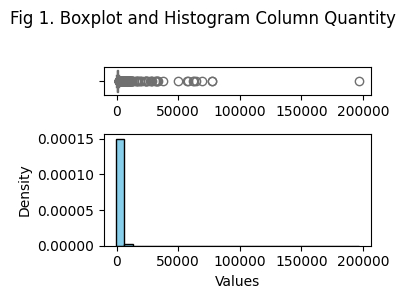

Data is not normally distributed


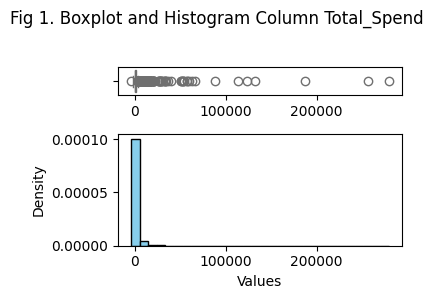

Data is not normally distributed


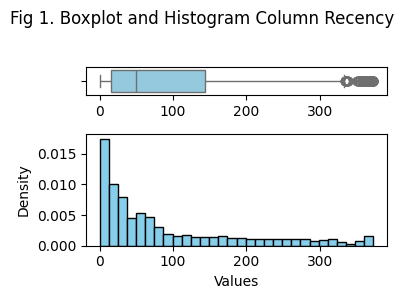

In [28]:
from scipy.stats import shapiro #determining distributions
for c in ['Quantity','Total_Spend','Recency']:
    isNormalDistributed(customer_df,c)
    hist_boxplot(customer_df,c)

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
customer_df_encoded[['Quantity', 'Total_Spend','Recency']] = scaler.fit_transform(customer_df_encoded[['Quantity', 'Total_Spend','Recency']])


In [30]:
customer_df_scaled = customer_df_encoded.copy()
customer_df_scaled.head(3)

,Quantity,Total_Spend,Recency,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,0.001538,0.015107,0.871314,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.014014,0.030295,0.005362,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.013420,0.021439,0.201072,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



### Dimensionality Reduction

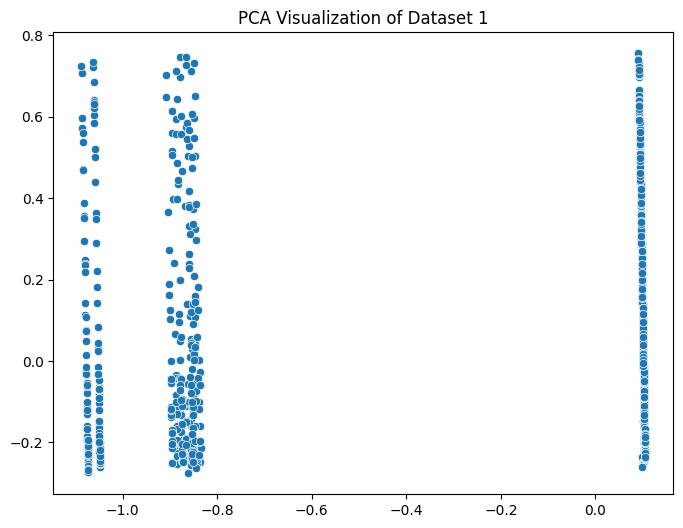

In [31]:
#Dimensionality Reduction using PCA
pca = PCA(n_components=2)
df1_pca = pca.fit_transform(customer_df_scaled)

# Visualize Dataset_1 PCA Results
plt.figure(figsize=(8,6))
sns.scatterplot(x=df1_pca[:, 0], y=df1_pca[:, 1])
plt.title("PCA Visualization of Dataset 1")
plt.show()

## Clustering Implementation



### Denclue Implementation 

In [32]:
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Gaussian Kernel function for d-dimensional data
def gaussian_kernel(distance, bandwidth, d):
    return np.exp(-0.5 * (np.sum((distance / bandwidth) ** 2, axis=1))) / ((bandwidth * np.sqrt(2 * np.pi)) ** d)

# FindAttractor function for d-dimensional data
def find_attractor(x, data, bandwidth, epsilon=1e-3, max_iter=100):
    x_t = np.array(x, dtype=float)
    d = data.shape[1]  # Dynamically get the dimensionality
    for _ in range(max_iter):
        # Compute kernel density weights
        distances = data - x_t  # Difference vector for each point
        weights = gaussian_kernel(distances, bandwidth, d)
        
        # Compute new position as density-weighted mean
        x_t_next = np.sum(weights[:, None] * data, axis=0) / np.sum(weights)
        
        # Stopping condition
        if np.linalg.norm(x_t_next - x_t) < epsilon:
            break
        x_t = x_t_next
    return tuple(x_t)

# DENCLUE Clustering Algorithm for d-dimensional data
def denclue(data, bandwidth, density_threshold, epsilon=1e-3):
    attractors = {}
    clusters = {}
    d = data.shape[1]  # Dynamically get the dimensionality
    
    for x in data:
        x_star = find_attractor(x, data, bandwidth, epsilon)
        
        # Assign to existing attractor or create new one
        if x_star in attractors:
            attractors[x_star].append(tuple(x))
        else:
            attractors[x_star] = [tuple(x)]
    
    # Filter clusters by density threshold
    for i, (attractor, points) in enumerate(attractors.items()):
        if len(points) >= density_threshold:
            clusters[i] = np.array(points)
    return clusters

In [33]:
data = np.array(df1_pca, dtype=float)  # Ensure numerical format

def silverman_bandwidth(data):
    sigma = np.std(data, axis=0)  # Standard deviation
    n = len(data)  # Number of points
    return 1.06 * sigma * n**(-1/5)

h = silverman_bandwidth(data)
print("Suggested bandwidth (h):", h)

Suggested bandwidth (h): [0.0619912  0.05356627]


In [34]:
# Run DENCLUE
bandwidth = 0.061 # Smoothness parameter
density_threshold = 5  # Minimum points per cluster
clusters = denclue(data, bandwidth, density_threshold)
# KDE Density Estimation and Plot
x_values = data[:, 0]  
kde = gaussian_kde(x_values, bw_method=bandwidth)
x_grid = np.linspace(min(x_values), max(x_values), 100)
kde_values = kde(x_grid)

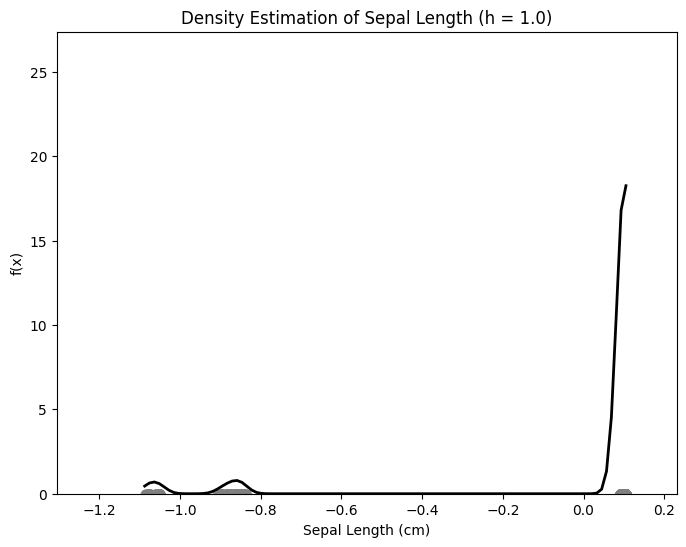

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(x_grid, kde_values, 'k-', linewidth=2)  # Density curve
plt.scatter(x_values, np.zeros_like(x_values), color='gray', alpha=0.5)  # Data points at bottom
plt.xlabel("Sepal Length (cm)")
plt.ylabel("f(x)")
plt.title("Density Estimation of Sepal Length (h = 1.0)")
plt.ylim(0, max(kde_values) * 1.5)  # Adjust y-axis to fit the density curve
plt.xlim(min(x_grid)*1.2, max(x_grid)*2.2)  # Adjust y-axis to fit the density curve
plt.show()

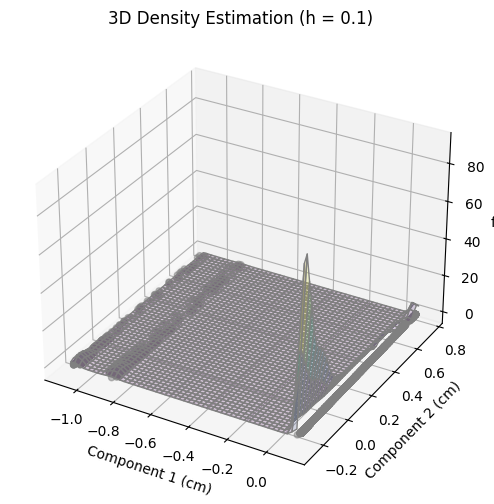

In [36]:
# KDE Density Estimation for 3D Surface Plot
x_values, y_values = data[:, 0], data[:, 1]
kde = gaussian_kde(np.vstack([x_values, y_values]), bw_method=bandwidth)

x_grid, y_grid = np.meshgrid(np.linspace(min(x_values), max(x_values), 50),
                             np.linspace(min(y_values), max(y_values), 50))
z_values = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

# 3D Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_values, edgecolor='gray', alpha=0.2,cmap='viridis')
ax.scatter(x_values, y_values, np.zeros_like(x_values), color='gray', alpha=0.5)
ax.set_xlabel("Component 1 (cm)")
ax.set_ylabel("Component 2 (cm)")
ax.set_zlabel("f(x)")
ax.set_title("3D Density Estimation (h = 0.1)")
plt.show()